In [2]:
!pip install editdistance -q

In [3]:
# Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [5]:
import pandas as pd
import numpy as np
import editdistance
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load the eval files for each model's translations
final = pd.read_csv(D+"/predicted_text/siamese_evaluations_of_translations/record_comparison.csv")
final.drop(columns={'Unnamed: 0'}, inplace=True)

In [7]:
# View the first few records in each file
final.head()

,language_task,target_sentence,bart_translation,bart_paraphrase_score,bart_cosine_score,indictrans_translation,indictrans_paraphrase_score,indictrans_cosine_score,best_trans
0,translate English to Hindi,प्रधानमंत्री ने कहा कि बाबा साहेब अम्बेडकर की ...,Prime Minister said Babasaheb Ambedkar has a k...,0.088514,0.770237,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...,0.974685,0.948379,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...
1,translate English to Hindi,इस समारोह को आज बीजापुर में आयोजित करने के महत...,आज बीजापुर में इस समारोह को आयोजित करने के महत...,0.979257,0.946777,आज बीजापुर में इस कार्यक्रम के आयोजन के महत्व ...,0.978843,0.973164,आज बीजापुर में इस समारोह को आयोजित करने के महत...
2,translate English to Hindi,उन्होंने कहा कि इस कार्य को 2022 तक पूरा कर ले...,उन्होंने कहा कि लक्ष्य 2022 तक इस कार्य को पूर...,0.986500,0.956433,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...,0.987696,0.985965,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...
3,translate English to Hindi,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.980670,0.965325,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.986279,0.986373,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...
4,translate English to Hindi,"उन्होंने इस संदर्भ में जन धन खाता खोलने, गरीबो...","इस संदर्भ में उन्होंने जनधन खाते खोलने, गरीबों...",0.984052,0.979276,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो...",0.985711,0.992806,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो..."


In [8]:
# Add a new column for the source of the best translation
final['best_trans_source'] = np.where(final.best_trans == final.indictrans_translation, "indictrans", "mbart")

In [40]:
# Add a new column based upon whether or not cosine similarity score went up or down
conditions = [
    (final['best_trans_source'] == 'indictrans') & (final['indictrans_cosine_score'] > final['bart_cosine_score']),
    (final['best_trans_source'] == 'indictrans') & (final['indictrans_cosine_score'] < final['bart_cosine_score']),
    (final['best_trans_source'] == 'indictrans') & (final['indictrans_cosine_score'] == final['bart_cosine_score']),
    (final['best_trans_source'] == 'mbart') & (final['bart_cosine_score'] > final['indictrans_cosine_score']),
    (final['best_trans_source'] == 'mbart') & (final['bart_cosine_score'] < final['indictrans_cosine_score']),
    (final['best_trans_source'] == 'mbart') & (final['bart_cosine_score'] == final['bart_cosine_score'])
    ]
values = ['score increased', 'score decreased', 'no change', 'score increased', 'score decreased', 'no change']

final['cos_change'] = np.select(conditions, values)

In [41]:
# Create a scatterplot of cosine similarity scores and paraphrase probability scores
# Add a column for the best translation cosine similarity score and another for best translation paraphrase score
final['best_paraphrase_cos'] = np.where(final.best_trans_source == 'mbart', final.bart_cosine_score, final.indictrans_cosine_score)
final['best_paraphrase_para'] = np.where(final.best_trans_source == 'mbart', final.bart_paraphrase_score, final.indictrans_paraphrase_score)

In [56]:
final.language_task = final['language_task'].str.replace('translate English to Hindi', 'Hindi').str.replace('translate English to Tamil', 'Tamil').str.replace('translate English to Malayalam', 'Malayalam')

In [42]:
# The cosine similarity score of the sentence chosen by the paraphrase evaluator was higher than that of the non-chosen sentence 75% of the time
# 2,243 of 3,000 times
# in 724 cases, the cosine similarity score of the chosen sentence was lower than that of the non-chosen sentence
final.cos_change.value_counts()

score increased    2243
score decreased     724
no change            33
Name: cos_change, dtype: int64

In [43]:
# Add 2 new columns to calculate the character edit distance
# 1 between IndicTrans translation and target
# 1 for MBart translation and target
final['indictrans_edit'] = final.apply(lambda x: editdistance.eval(x['target_sentence'], x['indictrans_translation']), axis=1)
final['bart_edit'] = final.apply(lambda x: editdistance.eval(x['target_sentence'], x['bart_translation']), axis=1)

In [58]:
# Create a new column for the difference in edit distances between the translation chosen vs not chosen
final["editd_chosen"] = np.where(final.best_trans_source == 'mbart', final.bart_edit - final.indictrans_edit, 
                              final.indictrans_edit - final.bart_edit)

In [44]:
# Create sub dataframes for each translator when it was chosen as the best translation
indic_chosen = final[final.best_trans_source == 'indictrans']
mbart_chosen = final[final.best_trans_source == 'mbart']

In [45]:
# When Indictrans was chosen as the translation, the cosine similarity was higher than that the Bart translation 1,489 times out of 1,921
# 78% of the time
indic_chosen.cos_change.value_counts()

score increased    1489
score decreased     399
no change            33
Name: cos_change, dtype: int64

In [14]:
# Mbart's translation was chosen as the better translation 1,079 times
# 70% of the time, this replacement resulted in an increase in sentence similarity as measured by cosine similarity score
mbart_chosen.cos_change.value_counts()

score increased    754
score decreased    325
Name: cos_change, dtype: int64

In [15]:
final.columns

Index(['language_task', 'target_sentence', 'bart_translation',
       'bart_paraphrase_score', 'bart_cosine_score', 'indictrans_translation',
       'indictrans_paraphrase_score', 'indictrans_cosine_score', 'best_trans',
       'best_trans_source', 'cos_change', 'indictrans_edit', 'bart_edit'],
      dtype='object')

In [49]:
# Look at langage specific changes in cosine sentence similarity, then by language + translator used
# Initial Sacre Bleu scores were highest for Hindi from IndicTrans, MBart for Tamil, and IndicTrans for Malayalam
hi_cos_change = final[final.language_task == 'Hindi']
ta_cos_change = final[final.language_task == 'Tamil']
ml_cos_change = final[final.language_task == 'Malayalam']

In [50]:
# 793 of 1,000 times, the cosine similarity score for Hindi increased
# an additional 24 times there was no change
hi_cos_change.cos_change.value_counts()

score increased    793
score decreased    183
no change           24
Name: cos_change, dtype: int64

In [18]:
print(hi_cos_change[hi_cos_change.best_trans_source == 'indictrans'].cos_change.value_counts(), "\n")
print(hi_cos_change[hi_cos_change.best_trans_source == 'mbart'].cos_change.value_counts())

score increased    555
score decreased     81
no change           24
Name: cos_change, dtype: int64 

score increased    238
score decreased    102
Name: cos_change, dtype: int64


In [19]:
print(ta_cos_change.cos_change.value_counts(), "\n")
print(ta_cos_change[ta_cos_change.best_trans_source == 'indictrans'].cos_change.value_counts(), "\n")
print(ta_cos_change[ta_cos_change.best_trans_source == 'mbart'].cos_change.value_counts())

score increased    723
score decreased    268
no change            9
Name: cos_change, dtype: int64 

score increased    408
score decreased    124
no change            9
Name: cos_change, dtype: int64 

score increased    315
score decreased    144
Name: cos_change, dtype: int64


In [20]:
print(ml_cos_change.cos_change.value_counts(), "\n")
print(ml_cos_change[ml_cos_change.best_trans_source == 'indictrans'].cos_change.value_counts(), "\n")
print(ml_cos_change[ml_cos_change.best_trans_source == 'mbart'].cos_change.value_counts())

score increased    727
score decreased    273
Name: cos_change, dtype: int64 

score increased    526
score decreased    194
Name: cos_change, dtype: int64 

score increased    201
score decreased     79
Name: cos_change, dtype: int64


In [21]:
# See if the chosen translation has a higher/lower/the same character edit distance as the translation not chosen
print(len(indic_chosen[indic_chosen.indictrans_edit < indic_chosen.bart_edit]))
print(len(indic_chosen[indic_chosen.indictrans_edit == indic_chosen.bart_edit]))
print(len(indic_chosen[indic_chosen.indictrans_edit > indic_chosen.bart_edit]))

1496
88
337


In [22]:
print(len(mbart_chosen[mbart_chosen.bart_edit < mbart_chosen.indictrans_edit]))
print(len(mbart_chosen[mbart_chosen.bart_edit == mbart_chosen.indictrans_edit]))
print(len(mbart_chosen[mbart_chosen.bart_edit > mbart_chosen.indictrans_edit]))

447
43
589


In [23]:
hi_cos_change.columns

Index(['language_task', 'target_sentence', 'bart_translation',
       'bart_paraphrase_score', 'bart_cosine_score', 'indictrans_translation',
       'indictrans_paraphrase_score', 'indictrans_cosine_score', 'best_trans',
       'best_trans_source', 'cos_change', 'indictrans_edit', 'bart_edit'],
      dtype='object')

In [24]:
hi_cos_change.head()

,language_task,target_sentence,bart_translation,bart_paraphrase_score,bart_cosine_score,indictrans_translation,indictrans_paraphrase_score,indictrans_cosine_score,best_trans,best_trans_source,cos_change,indictrans_edit,bart_edit
0,translate English to Hindi,प्रधानमंत्री ने कहा कि बाबा साहेब अम्बेडकर की ...,Prime Minister said Babasaheb Ambedkar has a k...,0.088514,0.770237,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...,0.974685,0.948379,प्रधानमंत्री ने कहा कि करोड़ों लोगों के दिलों ...,indictrans,score increased,67,126
1,translate English to Hindi,इस समारोह को आज बीजापुर में आयोजित करने के महत...,आज बीजापुर में इस समारोह को आयोजित करने के महत...,0.979257,0.946777,आज बीजापुर में इस कार्यक्रम के आयोजन के महत्व ...,0.978843,0.973164,आज बीजापुर में इस समारोह को आयोजित करने के महत...,mbart,score decreased,56,43
2,translate English to Hindi,उन्होंने कहा कि इस कार्य को 2022 तक पूरा कर ले...,उन्होंने कहा कि लक्ष्य 2022 तक इस कार्य को पूर...,0.986500,0.956433,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...,0.987696,0.985965,उन्होंने कहा कि इस कार्य को 2022 तक पूरा करने ...,indictrans,score increased,3,26
3,translate English to Hindi,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.980670,0.965325,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,0.986279,0.986373,प्रधानमंत्री ने कहा कि सरकार स्पष्ट लक्ष्यों औ...,indictrans,score increased,3,3
4,translate English to Hindi,"उन्होंने इस संदर्भ में जन धन खाता खोलने, गरीबो...","इस संदर्भ में उन्होंने जनधन खाते खोलने, गरीबों...",0.984052,0.979276,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो...",0.985711,0.992806,"इस संदर्भ में उन्होंने जन धन खाते खोलने, गरीबो...",indictrans,score increased,38,58


In [25]:
# Print the edit distance for Hindi by translator chosen
# For Hindi, when IndicTrans was chosen as the best translator, it usually had a shorter edit distance
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'indictrans') & (hi_cos_change.indictrans_edit < hi_cos_change.bart_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'indictrans') & (hi_cos_change.indictrans_edit == hi_cos_change.bart_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'indictrans') & (hi_cos_change.indictrans_edit > hi_cos_change.bart_edit)]), "\n")

# For Hindi, when Bart was chosen as the best translator, the edit distance from the translated sentence to the target
# was close to the edit distances of the translated sentences from IndicTrans
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'mbart') & (hi_cos_change.bart_edit < hi_cos_change.indictrans_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'mbart') & (hi_cos_change.bart_edit == hi_cos_change.indictrans_edit)]))
print(len(hi_cos_change[(hi_cos_change.best_trans_source == 'mbart') & (hi_cos_change.bart_edit > hi_cos_change.indictrans_edit)]))

521
41
98 

160
17
163


In [26]:
# Print the edit distance for Tamil by translator chosen
# For Tamil, when IndicTrans was chosen as the best translator, it usually had a shorter edit distance
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'indictrans') & (ta_cos_change.indictrans_edit < ta_cos_change.bart_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'indictrans') & (ta_cos_change.indictrans_edit == ta_cos_change.bart_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'indictrans') & (ta_cos_change.indictrans_edit > ta_cos_change.bart_edit)]), "\n")

# For Tamil, when Bart was chosen as the best translator, the edit distance from the translated sentence to the target
# was close to the edit distances of the translated sentences from IndicTrans
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'mbart') & (ta_cos_change.bart_edit < ta_cos_change.indictrans_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'mbart') & (ta_cos_change.bart_edit == ta_cos_change.indictrans_edit)]))
print(len(ta_cos_change[(ta_cos_change.best_trans_source == 'mbart') & (ta_cos_change.bart_edit > ta_cos_change.indictrans_edit)]))

349
30
162 

221
19
219


In [27]:
# Print the edit distance for Tamil by translator chosen
# For Malayalam, when IndicTrans was chosen as the best translator, it usually had a shorter edit distance
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'indictrans') & (ml_cos_change.indictrans_edit < ml_cos_change.bart_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'indictrans') & (ml_cos_change.indictrans_edit == ml_cos_change.bart_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'indictrans') & (ml_cos_change.indictrans_edit > ml_cos_change.bart_edit)]), "\n")

# For Malayalam, when Bart was chosen as the best translator, the edit distance from the translated sentence to the target
# tends to be greater than the edit distances of the translated sentences from IndicTrans
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'mbart') & (ml_cos_change.bart_edit < ml_cos_change.indictrans_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'mbart') & (ml_cos_change.bart_edit == ml_cos_change.indictrans_edit)]))
print(len(ml_cos_change[(ml_cos_change.best_trans_source == 'mbart') & (ml_cos_change.bart_edit > ml_cos_change.indictrans_edit)]))

626
17
77 

66
7
207


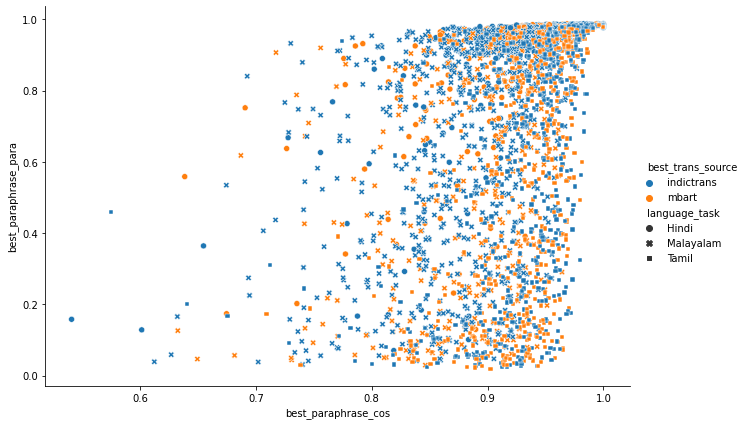

In [33]:
sns.relplot(x="best_paraphrase_cos", y="best_paraphrase_para", hue="best_trans_source", style="language_task", data=final,
            height=6, aspect=1.5)

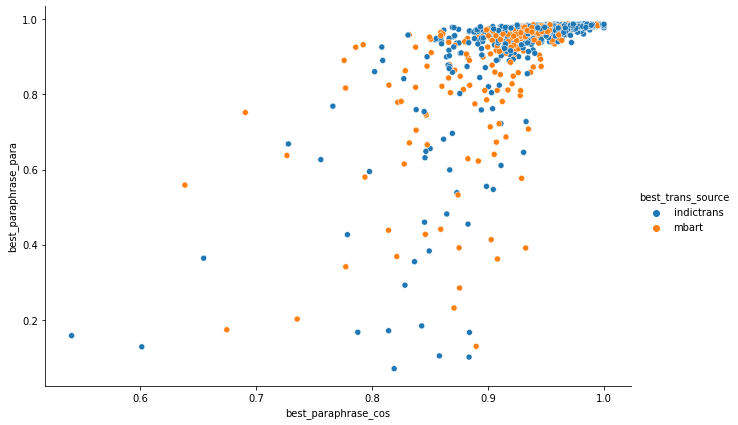

In [51]:
sns.relplot(x="best_paraphrase_cos", y="best_paraphrase_para", hue="best_trans_source", data=hi_cos_change,
            height=6, aspect=1.5)

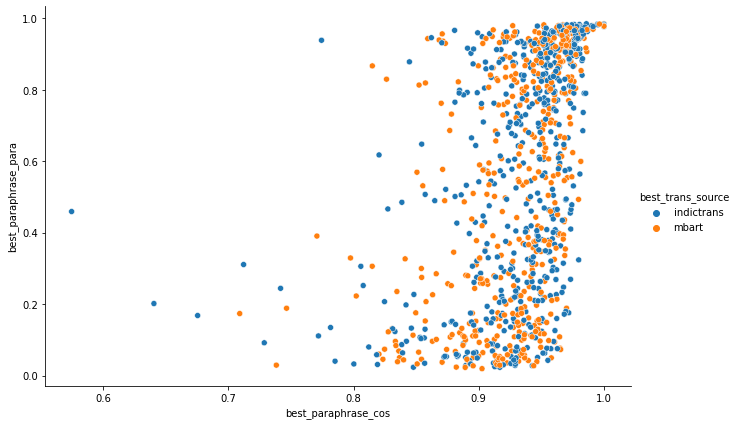

In [52]:
sns.relplot(x="best_paraphrase_cos", y="best_paraphrase_para", hue="best_trans_source", data=ta_cos_change,
            height=6, aspect=1.5)

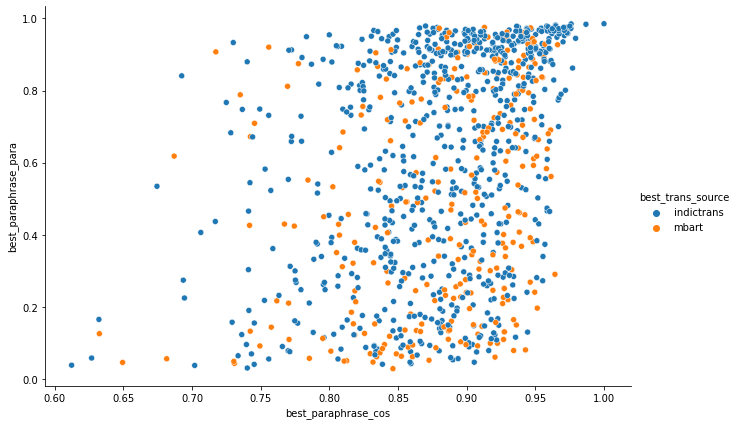

In [53]:
sns.relplot(x="best_paraphrase_cos", y="best_paraphrase_para", hue="best_trans_source", data=ml_cos_change,
            height=6, aspect=1.5)